In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy import integrate
import logging
import importlib
import os

from pynwb import NWBHDF5IO

import ephys_extractor as efex
import ephys_features as ft
sns.set_style()

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from sklearn import linear_model
ransac = linear_model.RANSACRegressor()

%matplotlib inline

# Load and process data

IMPORTANT: this notebook can work with two types of input data: .mat files generated from patch-master and nwb files which are stantard in the patch-clamp field (all provided your .mat file/nwb file has certain keys and structure). Depending on your type of input data, generate a time 1d array, voltage 2d array, current 1d array and index corresponding to zero current stimulation integer from the correct corresponding function. Said differently: if you have a nwb file, use get_time_current_voltage_curr_index0(nwb), if you have a .mat file, use data_preparation(data, el_num=2). Also see https://github.com/ben-dichter-consulting/tolias-lab-to-nwb with code of how all .mat files have been coverted to nwb files.

In [2]:
def get_time_voltage_current_currindex0(nwb):
    df = nwb.sweep_table.to_dataframe()
    voltage = np.zeros((len(df['series'][0][0].data[:]), int((df.shape[0]+1)/2)))
    time = np.arange(len(df['series'][0][0].data[:]))/df['series'][0][0].rate
    #time = np.array([round(c, 5) for c in time])
    voltage[:, 0] = df['series'][0][0].data[:]
    current_initial = df['series'][1][0].data[12000]*df['series'][1][0].conversion
    curr_index_0 = int(-current_initial/20) # index of zero current stimulation
    current = np.linspace(current_initial, (int((df.shape[0]+1)/2)-1)*20+current_initial, \
                         int((df.shape[0]+1)/2))
    for i in range(curr_index_0):   # Find all voltage traces from minimum to  0 current stimulation
        voltage[:, i+1] = df['series'][0::2][(i+1)*2][0].data[:]
    for i in range(curr_index_0, int((df.shape[0]+1)/2)-1):   # Find all voltage traces from 0 to highest current stimulation
        voltage[:, i+1] = df['series'][1::2][i*2+1][0].data[:]
    voltage[:, curr_index_0] = df.loc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation
    return time, voltage, current, curr_index_0

In [3]:
def data_preparation(data, el_num = 2, current_step = 20):
    """Analyse the data in dictionary format (assumes a certain outlook of the data) and return the voltage traces, 
    stimulus current magnitudes for all traces, the time and the current index for which the current magnitude equals 0 pA.

    Parameters
    ----------
    data : dictionary full of voltage (V) and time (s) traces
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    """
    
    
    
    # All the keys in the dictionary should have the form "Trace_1_j_c_el" where j represents a certain number which could
    # be different between cells/samples, therefore we will store this number as num. c represents the current stimulus
    # magnitude index, el the electrode number. They usually always record from electrode number el = 2.

    
    # Random initialisations
    num = 2
    n_samp = 22500
    dt = 4e-05
    
    big_data = True
    
    if len(data.keys()) == 83:                     # We're in the special case of 4 datafiles where raw data is one
                                                   # electrode only
            big_data = False
    
    for key in list(data)[1:6]:
        if key.split('_')[0] == "Trace":
            num = key.split('_')[2]
            n_samp = data[key].shape[0] # Amount of timepoints
            dt = data[key][1, 0] - data[key][0, 0] # Time step
            
            if not big_data:
                el_num = key.split('_')[4]
                
            break
    time = np.arange(0,n_samp*dt,dt)
    
    
    # Check whether we have hyperpolarisation in the beginning, otherwise the electrode where APs have been recorded
    # must have been a different one
    
    
    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
    voltage_deflection_v, _ = object_ephys.voltage_deflection()
    Vm = object_ephys._get_baseline_voltage()
    V_defl = voltage_deflection_v
    if  np.abs(Vm - V_defl) < 2:
        el_num = 1
        while np.abs(Vm - V_defl) < 2:
            object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
            Vm = object_ephys._get_baseline_voltage()
            V_defl, _ = object_ephys.voltage_deflection()
            if el_num == 1: # We already investigated el_num = 2
                el_num = 3
            else: el_num += 1
        el_num = el_num - 1
    
    Amount_Of_Electrodes = np.max([int(g.split('_')[-1]) if (g.split('_')[0] == 'Trace') else 0 for g in list(data.keys())])
    # stim_paradigm_num is the number of current stimulus magnitudes that were used
    stim_paradigm_num = (np.array(list(data)).size - 3)/Amount_Of_Electrodes
                                    # 3 keys should just be '__globals__', '__header__', and '__version__'
 
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    
    # Trace with the least amount of variance in the trace is assumed to be the trace corresponding to stimulating the cell
    # with 0 pA stimulation current
    best = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1])
    #best = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1]) - Vm)
    for i in np.arange(2, stim_paradigm_num + 1, 1, dtype = 'int'):
        best_temp = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1])
        #best_temp = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    
    start_current_impulse = -(curr_index_0 - 1)*current_step # - 1 since in the dictionary we start at 1 (not at zero)    
    stop_current_impulse = start_current_impulse + (current_step*stim_paradigm_num)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    #current = current[current < 800] #After that the cell might die and it's probably unnecessary for the analysis
    
    # voltage will give us the voltage response for all different current steps
    voltage = np.zeros((n_samp, len(current)))
    for c, C in enumerate(current):
        voltage[:,c] = 1000*data['Trace_1_{}_{}_{}'.format(num, c+1, el_num)][:,1] # c+1: goes from 1 to end of possible current
                                                                                   # stimulation magnitudes
    
    return time, current, voltage, (curr_index_0 - 1) # -1 since the current and voltage vector start at 0

If you have both files .nwb and .mat you can check whether they give the same

In [21]:
fpath = '../M1/NWBData/20191104_sample_3.nwb'
io_ = NWBHDF5IO(fpath, 'r', load_namespaces=True)
nwb = io_.read()

/usr/local/lib/python3.7/dist-packages/hdmf/spec/namespace.py:470: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/usr/local/lib/python3.7/dist-packages/hdmf/spec/namespace.py:470: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [22]:
data = io.loadmat('../M1/data/2019/nov/11 04 2019/11 04 2019 sample 3.mat')

In [23]:
time, voltage, current, curr_index_0 = get_time_voltage_current_currindex0(nwb)
print('time: ', time, '\nvoltage: ', voltage, '\ncurrent: ', current, '\ncurr_index_0: ', curr_index_0)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 9.9988e-01 9.9992e-01 9.9996e-01] 
voltage:  [[-61.11010164 -60.0190945  -60.2732636  ... -60.2904819  -60.03695354
  -60.44731289]
 [-61.13668531 -60.04866585 -60.23861468 ... -60.26691943 -60.06214768
  -60.42382121]
 [-61.16209179 -60.07773802 -60.20781025 ... -60.2449663  -60.08683145
  -60.40183455]
 ...
 [-59.37206745 -59.99102816 -59.66645852 ... -60.9636493  -61.18449941
  -60.80521643]
 [-59.36570093 -59.9819608  -59.71647054 ... -60.93655527 -61.21265516
  -60.74015424]
 [-59.35550854 -59.97346342 -59.77260694 ... -60.90487912 -61.24218181
  -60.67007035]] 
current:  [-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.  260.
  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.  500.
  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.  740.
  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.  980.
 1000.

In [24]:
time, current, voltage, curr_index_0 = data_preparation(data, el_num = 2)
print('time: ', time)
print('\n\ncurrent: ', current)
print('\n\nvoltage: ', voltage)
print('\n\ncurr_index_0: ', curr_index_0)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 9.9988e-01 9.9992e-01 9.9996e-01]


current:  [-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.  260.
  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.  500.
  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.  740.
  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.  980.
 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180. 1200. 1220.
 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380.]


voltage:  [[-61.11010164 -60.0190945  -60.2732636  ... -60.2904819  -60.03695354
  -60.44731289]
 [-61.13668531 -60.04866585 -60.23861468 ... -60.26691943 -60.06214768
  -60.42382121]
 [-61.16209179 -60.07773802 -60.20781025 ... -60.2449663  -60.08683145
  -60.40183455]
 ...
 [-59.37206745 -59.99102816 -59.66645852 ... -60.9636493  -61.18449941
  -60.80521643]
 [-59.36570093 -59.9819608  -59.71647054 ... -60.9365552

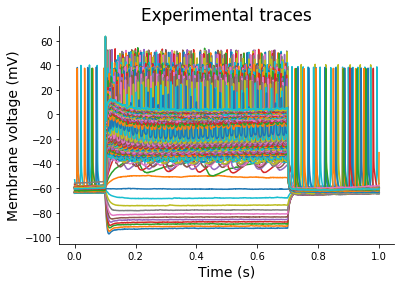

In [25]:
# UNCOMMENT if you'd like to see the data plotted

import seaborn as sns
sns.set_style()
plt.plot(time, voltage);
plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Membrane voltage (mV)', fontsize = 14)
plt.title('Experimental traces', fontsize = 17)
sns.despine()

In [65]:
# The no biocytin neurons showed no significant differences in terms of their electrophysiology w.r.t. other neurons where
# biocytin was in the solution.

M1_nwb = []
M1_nwb_names = []
for root, dirs, files in os.walk('../M1/NWBData'):
    if files:
        for file in files:
            if file.endswith('.nwb'):
                M1_nwb.append(NWBHDF5IO(root + '/' + file, 'r', load_namespaces=True).read())
                M1_nwb_names.append(root + '/' + file)

In [28]:
# M1 data .mat files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
M1 = []
M1_names = []
for root, dirs, files in os.walk('../M1/data/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                M1.append(io.loadmat(root + '/' + file))
                M1_names.append(root + '/' + file)

In [250]:
# # The no biocytin neurons showed no significant differences in terms of their electrophysiology w.r.t. other neurons where
# # biocytin was in the solution.

# M1_no_biocytin = []
# M1_names_no_biocytin = []
# for root, dirs, files in os.walk('../M1/2018/DecNoBiocytin/'):
#     if files:
#         for file in files:
#             if file.endswith('.mat'):
#                 M1_no_biocytin.append(io.loadmat(root + '/' + file))
#                 M1_names_no_biocytin.append(root + '/' + file)

In [44]:
# M1 revision data .mat files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
M1_rev = []
M1_rev_names = []
for root, dirs, files in os.walk('../M1_revision/data'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                M1_rev.append(io.loadmat(root + '/' + file))
                M1_rev_names.append(root + '/' + file)

# Analysing action potentials

In [5]:
def extract_spike_features(time, current, voltage, start = 0.1, end = 0.7, fil = 10):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df], sort = True)

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding spike frequency adaptation (ratio of spike frequency of second half to first half)
        SFA = np.nan
        half_stim_index = ft.find_time_index(time, np.float(start + (end-start)/2))
        if spike_count > 5: # We only consider traces with more than 8.333 Hz = 5/600 ms spikes here
                            # but in the end we only take the trace with the max amount of spikes
            
            if np.sum(df.loc[df['threshold_i'] == curr, :]['threshold_index'] < half_stim_index)!=0:
                SFA = np.sum(df.loc[df['threshold_i'] == curr, :]['threshold_index'] > half_stim_index) / \
                  np.sum(df.loc[df['threshold_i'] == curr, :]['threshold_index'] < half_stim_index)
        
        df_features.update({'SFA': SFA})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection to steady state (mV)
        voltage_deflection_SS = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
        #voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection() # = old way: max deflection
        df_features.update({'voltage_deflection': voltage_deflection_SS})
        
        # Adding input resistance (MOhm)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances 
                                                                            # from traces without APs
            input_resistance = (np.abs(voltage_deflection_SS - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms
        # after stimulus onset
        tau = np.nan
        E_plat = np.nan
        sag_ratio = np.nan
        if curr < 0:            # We use hyperpolarising steps as required in the object function to estimate the
                                # membrane time constant and E_plateau
            while True:
                try:
                    tau = EphysObject.estimate_time_constant()  # Result in seconds!
                    break
                except TypeError: # Probably a noisy bump for this trace, just keep it to be np.nan
                    break
            E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
            sag, sag_ratio = EphysObject.estimate_sag()
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})
        df_features.update({'sag_ratio': sag_ratio})
        
        # For the rebound and sag time we only are interested in the lowest (-200 pA (usually)) hyperpolarisation trace
        rebound = np.nan
        sag_time = np.nan
        sag_area = np.nan
        
        if c==0:
            baseline_interval = 0.1 # To calculate the SS voltage
            v_baseline = EphysObject._get_baseline_voltage()
            
            
            end_index = ft.find_time_index(time, 0.7)
            if np.flatnonzero(voltage[end_index:, c] > v_baseline).size == 0: # So perfectly zero here means
                                                                              # it did not reach it
                rebound = 0
            else:
                index_rebound = end_index + np.flatnonzero(voltage[end_index:, c] > v_baseline)[0]
                if not (time[index_rebound] > (end + 0.15)): # We definitely have 150 ms left to calculate the rebound
                    rebound = ft.average_voltage(voltage[index_rebound:index_rebound + ft.find_time_index(time, 0.15), c], \
                                         time[index_rebound:index_rebound + ft.find_time_index(time, 0.15)]) - v_baseline
                else:                                       # Work with whatever time is left
                    if time[-1] == time[index_rebound]:
                        rebound=0
                    else:
                        rebound = ft.average_voltage(voltage[index_rebound:, c], \
                                         time[index_rebound:]) - v_baseline

            v_peak, peak_index = EphysObject.voltage_deflection("min")
            v_steady = ft.average_voltage(voltage[:, c], time, start = end - baseline_interval, end=end)
            
            if v_steady - v_peak < 4: # The sag should have a minimum depth of 4 mV
                                      # otherwise we set sag time and sag area to 0
                sag_time = 0
                sag_area = 0
            else:
                #First time SS is reached after stimulus onset
                first_index = start_index + np.flatnonzero(voltage[start_index:peak_index, c] < v_steady)[0]
                # First time SS is reached after the max voltage deflection downwards in the sag
                if np.flatnonzero(voltage[peak_index:end_index, c] > v_steady).size == 0: 
                    second_index = end_index
                else:
                    second_index = peak_index + np.flatnonzero(voltage[peak_index:end_index, c] > v_steady)[0]
                sag_time = time[second_index] - time[first_index]
                sag_area = -integrate.cumtrapz(voltage[first_index:second_index, c], time[first_index:second_index])[-1]


        burst_metric = np.nan
        #print(c)
        if spike_count > 5:
            burst = EphysObject._process_bursts()
            if len(burst) != 0:
                burst_metric = burst[0][0]
            
        df_features.update({'rebound': rebound})
        df_features.update({'sag_time': sag_time})
        df_features.update({'sag_area': sag_area})
        df_features.update({'burstiness': burst_metric})

        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])], sort = True)
    
    return df, df_related_features

In [426]:
df, df_related_features = extract_spike_features(time, current, voltage)

In [411]:
df_, df_related_features_ = extract_spike_features(time_, current_, voltage_)

In [7]:
# Here is an example on how you can query certain things from these DataFrames

max_freq = np.max(df_related_features['spike_count'].values)
df_related_features.loc[df_related_features['spike_count'] == max_freq, ['fano_factor', 'cv', 'AP_fano_factor', 'AP_cv', 'current']]

,fano_factor,cv,AP_fano_factor,AP_cv,current
0,0.002318,0.299620,2.482416,0.214480,800.0
0,0.002416,0.306612,2.590412,0.221054,820.0


In [6]:
def get_cell_features(df, df_related_features, time, current, voltage, curr_index_0, \
                      current_step = 20, axis = None, start = 0.1, end = 0.7):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Vm, mV), the input resistance (R_input, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential width (AP width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    axis : figure axis object (optional, None by default)
    start : start of stimulation interval (s, optional)
    end : end of stimulation interval (s, optional)
    
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """

    tau_array = df_related_features['tau'].dropna().values
    Rm_array = df_related_features['resting_membrane_potential'][:curr_index_0].dropna().values
    Ri_array = df_related_features['input_resistance'][:curr_index_0].dropna().values
    tau = np.median(tau_array)*1000
    Rm = np.median(Rm_array)
    Ri = np.median(Ri_array)
    
    sag_ratio = df_related_features['sag_ratio'].values[0] # Steepest hyperpolarising trace used
    rebound = df_related_features['rebound'].values[0] # Steepest hyperpolarising trace used
    sag_time = df_related_features['sag_time'].values[0] # Steepest hyperpolarising trace used
    sag_area = df_related_features['sag_area'].values[0] # Steepest hyperpolarising trace used
    
    if axis:
        ax = axis
    else: figure_object, ax = plt.subplots(figsize = (10, 5))
    
    
    if not df.empty:
        # The max amount of spikes in 600 ms of the trace showing the max amount of spikes in 600 ms
        max_freq = np.max(df_related_features['spike_count'].values)
        # Take the first trace showing this many spikes if there are many
        current_max_freq = np.flatnonzero(df_related_features['spike_count'].values >= max_freq)[0]
        
        
        
        # Rebound firing
        rebound_spikes = 0
        EphysObject_rebound = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                      v = voltage[ft.find_time_index(time, end):, 0], \
                                                      i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                      start = end, end = time[-1])
        EphysObject_rebound.process_spikes()
        if EphysObject_rebound._spikes_df.size:
            rebound_spikes = EphysObject_rebound._spikes_df['threshold_i'].values.size
        

        # Check if there are APs outside the stimilation interval for the highest firing trace. When true, continue looking
        # for lower firing traces untill it shows none anymore. We don't want the neuron to have gone 'wild' (i.e. dying).
        current_max_freq_initial = current_max_freq # to see for which cells there is going to be much of a difference
        artifact_occurence = False
        EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                      v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                      i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                      start = end, end = time[-1])
        EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)+1], \
                                                      v = voltage[:ft.find_time_index(time, start)+1, current_max_freq], \
                                                      i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                      start = 0, end = start)

        EphysObject_end.process_spikes()
        EphysObject_start.process_spikes()
        if EphysObject_end._spikes_df.size or EphysObject_start._spikes_df.size:
                    artifact_occurence = True
        while artifact_occurence:
            current_max_freq-=1

            EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                      v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                      i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                      start = end, end = time[-1])
            EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)+1], \
                                                      v = voltage[:ft.find_time_index(time, start)+1, current_max_freq], \
                                                      i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                      start = 0, end = start)
            EphysObject_end.process_spikes()
            EphysObject_start.process_spikes()
            if not EphysObject_end._spikes_df.size and not EphysObject_start._spikes_df.size:
                artifact_occurence = False
        
        
        # Adding wildness: the feature that for neurogliaform cells specifically can describe whether for highest firing
        # traces the cell sometimes shows APs before and/or after the current stimulation window.
        wildness = df_related_features.iloc[current_max_freq_initial, :].loc['spike_count'] - \
                    df_related_features.iloc[current_max_freq, :].loc['spike_count']
        
        # Adding spike frequency adaptation (ratio of spike frequency of second half to first half for the highest
        # frequency count trace)
        if df_related_features.iloc[current_max_freq, :].loc['spike_count'] < 5: # If less than 5 spikes we choose not
                                                                                 # to calculate the SFA ==> np.nan
            SFA = np.nan
        else:
            SFA = df_related_features.iloc[current_max_freq, :].loc['SFA']
        # Note: we are trying to make sure that if SFA is 0, that it is actually 0 in the way it is defined 
        
        
        # Adding the Fano factor, a measure of the dispersion of a probability distribution (std^2/mean of the isis)
        # Adding the coefficient of variation. Time intervals between Poisson events should follow an exponential distribution
        # for which the cv should be 1. So if the neuron fires like a Poisson process a cv = 1 should capture that.
        fano_factor = df_related_features.iloc[current_max_freq, :].loc['fano_factor']
        cv = df_related_features.iloc[current_max_freq, :].loc['cv']
        AP_fano_factor = df_related_features.iloc[current_max_freq, :].loc['AP_fano_factor']
        AP_cv = df_related_features.iloc[current_max_freq, :].loc['AP_cv']
        
        
        # Do we have non-Nan values for the burstiness feature?
        non_nan_indexes_BI = ~np.isnan(df_related_features['burstiness'].values)
        if non_nan_indexes_BI.any():
            
            # Consider only the first and first 5 after threshold reached if possible
            # np.sum will consider a True as a 1 here and a False as a 0 (so you count the True's effectively)
            
            if np.sum(non_nan_indexes_BI) >= 5:
                BI_array = df_related_features['burstiness'].values[non_nan_indexes_BI][0:5]
                burstiness = np.median(BI_array)
            else: # Take everything you have
                BI_array = df_related_features['burstiness'].values[non_nan_indexes_BI]
                burstiness = np.median(BI_array)
            if burstiness < 0:
                burstiness = 0
        else:
            burstiness = 0
        
        
        # Do we have non-Nan values for the adaptation index (i.e. traces with more than 1 spike)? We can use this to
        # calculate AP amplitude changes too
        non_nan_indexes_AI = ~np.isnan(df_related_features['isi_adapt'].values)
        
        if non_nan_indexes_AI.any():
            
            # Consider only the first 5 after threshold reached if possible
            # np.sum will consider a True as a 1 here and a False as a 0 (so you count the True's effectively)
            
            if  np.sum(non_nan_indexes_AI) >= 5:
                ISI_adapt_array = df_related_features['isi_adapt'].values[non_nan_indexes_AI][0:5]
                ISI_adapt = np.median(ISI_adapt_array)
                ISI_adapt_average_array = df_related_features['isi_adapt_average'].values[non_nan_indexes_AI][0:5]
                ISI_adapt_average = np.median(ISI_adapt_average_array)
                AP_amp_adapt_array = df_related_features['AP_amp_adapt'].values[non_nan_indexes_AI][0:5]
                AP_amp_adapt = np.median(AP_amp_adapt_array)
                AP_amp_adapt_average_array = df_related_features['AP_amp_adapt_average'].values[non_nan_indexes_AI][0:5]
                AP_amp_adapt_average = np.median(AP_amp_adapt_average_array)
                
            else: # Take everything you have
                ISI_adapt_array = df_related_features['isi_adapt'].values[non_nan_indexes_AI]
                ISI_adapt = np.median(ISI_adapt_array)
                ISI_adapt_average_array = df_related_features['isi_adapt_average'].values[non_nan_indexes_AI]
                ISI_adapt_average = np.median(ISI_adapt_average_array)
                AP_amp_adapt_array = df_related_features['AP_amp_adapt'].values[non_nan_indexes_AI]
                AP_amp_adapt = np.median(AP_amp_adapt_array)
                AP_amp_adapt_average_array = df_related_features['AP_amp_adapt_average'].values[non_nan_indexes_AI]
                AP_amp_adapt_average = np.median(AP_amp_adapt_average_array)

        else:
            ISI_adapt = np.nan
            ISI_adapt_average = np.nan
            AP_amp_adapt = np.nan
            AP_amp_adapt_average = np.nan
        
        # We calculate the latency: the time it takes to elicit the first AP
        df_latency = df_related_features[df_related_features['current'] > 0]
        non_nan_indexes_latency = ~np.isnan(df_latency['latency'].values)
        # Only the first AP is considered for the first trace for which the current clamp stimulation is higher than the
        # current hold
        latency = df_latency['latency'].values[non_nan_indexes_latency][0]*1000
        latency_2 = df_latency['latency'].values[non_nan_indexes_latency][1]*1000

        # First index where there is an AP and the current stimulation magnitude is positive
        index_df =  np.where(df.loc[0]['fast_trough_i'].values[~np.isnan(df.loc[0]['fast_trough_i'].values)] > 0)[0][0]
        
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[index_df] - df.loc[0]['threshold_v'].values[index_df]
            # Only first AP is considered
        else:
            AHP = 0
    
        # ADP (alculated w.r.t. AHP)
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[index_df] - df.loc[0]['fast_trough_v'].values[index_df]
            # Only first AP is considered
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[index_df] # Only first AP is considered
                AP_amplitude = df.loc[0]['peak_height'].values[index_df] # Only first AP is considered
                AP_width = 1000*df.loc[0]['width'].values[index_df] # Only first AP is considered
                UDR = df.loc[0]['upstroke_downstroke_ratio'].values[index_df] # Only first AP is considered 
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first AP is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first AP is considered
                AP_width = 1000*df.loc[0]['width'] # Only first AP is considered
                UDR = df.loc[0]['upstroke_downstroke_ratio'] # Only first AP is considered

        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_width = 0
        
        # We estimate the rheobase based on a few (i.e. 5)
        # suprathreshold currents steps. A linear fit of the spike frequency w.r.t. to the current injection values of
        # these steps should give the rheobase as the crossing with the x-axis. (Method almost in agreement with Alexandra
        # Naka et al.: "Complementary networks of cortical somatostatin interneurons enforce layer specific control.", 
        # they additionally use the subthreshold current step closest to the first suprathreshold one. We think that biases
        # the regression analysis somewhat). We take the min of the first current step showing spikes and the regression line crossing
        # with the x-axis, unless the crossing is at an intercept lower than the last current step still showing no spikes (in
        # that case the first current step showing spikes is simply taken as value for the rheoabse). This method should
        # approximate the rheobase well provided the stimulus interval is long (in our case 600 ms).
        # If a regression cannot be performed, then also simply take the first current step for which spikes have been observed 
        # (i.e. not the subthreshold current step!)
        
        # Only positive currents for this experimental paradigm (i.e. 'spikes' observed for negative currents should not
        # be there)
        df_rheobase = df_related_features[['current', 'spike_count']][df_related_features['current'] >= 0]
        if len(np.nonzero(df_rheobase['spike_count'].values)[0]) > 4:
            indices = np.nonzero(df_rheobase['spike_count'].values)[0][:5]
            counts = [list(df_rheobase['spike_count'].values[indices]).count(x) for x in \
                                          df_rheobase['spike_count'].values[indices]]
            if np.max(np.array(counts)) < 3:
                ransac.fit(df_rheobase['current'].values[indices].reshape(-1, 1), \
                           df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(end-start))
                line_X = np.concatenate((df_rheobase['current'].values[indices], \
                                         np.array([0]))).reshape(-1, 1)
                slope = ransac.estimator_.coef_[0][0]
                sub_thresh_curr = df_rheobase['current'].values\
                    [np.nonzero(df_rheobase['spike_count'].values)[0][0] - 1] # Last current step with no observed spikes
                first_supra_thresh_curr = df_rheobase['current'].values\
                    [np.nonzero(df_rheobase['spike_count'].values)[0][0]]  # First current step with observed spikes
                rheobase = -ransac.predict(np.array([0]).reshape(-1, 1))[0][0]/slope
                if  rheobase < sub_thresh_curr:
                        rheobase = first_supra_thresh_curr # Take the first current step for which spikes are observed
                elif rheobase > first_supra_thresh_curr:
                        rheobase = first_supra_thresh_curr # Take the first current step for which spikes are observed
                
            
                ax.plot(df_rheobase['current'].values[indices].reshape(-1, 1), \
                         df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(end-start), '.k', markersize = 15)
                ax.plot(line_X, ransac.predict(line_X), color = 'k')
                ax.set_xlabel('Current (pA)', fontsize = 17)
                ax.set_ylabel('Spike frequency (Hz)', fontsize = 17)
                ax.set_title('Rheobase estimation', fontsize = 20)
                ax.spines['top'].set_visible(False)
                ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
                ax.set_ylim([0, np.max(df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(end-start)) + 3])

                # Let's denote the membrane voltage clearly on the plot
                ax.plot(rheobase, 0, marker = "|", color = 'black', ms = 50)
                ax.annotate('', xy = (rheobase - 15, 2), \
                            xycoords = 'data', xytext = (rheobase, 2), \
                            textcoords = 'data', arrowprops = {'arrowstyle': '<-', 'connectionstyle': 'arc3', \
                                                               'lw': 2, 'ec': 'grey', 'shrinkB': 0})
                ax.annotate('rheobase', xy = (rheobase -15, 2), \
                            xycoords = 'data', xytext = (-15, 2), textcoords = 'offset points', color = 'k', fontsize = 15)
            else: # A subset can probably not be found by RANSAC to do a regression
                  # Just take the first current step for which spikes have been observed
                rheobase = df_rheobase['current'].values\
                                [np.nonzero(df_rheobase['spike_count'].values)[0][0]]

        else: # Not enough datapoints to calculate a rheobase
              # Just take the first current step for which spikes have been observed
            rheobase = df_rheobase['current'].values\
                            [np.nonzero(df_rheobase['spike_count'].values)[0][0]]
        
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        rebound_spikes = 0
        SFA = np.nan
        fano_factor = np.nan
        cv = np.nan
        norm_sq_isis = np.nan
        ISI_adapt = np.nan
        ISI_adapt_average = np.nan
        AP_amp_adapt = np.nan
        AP_amp_adapt_average = np.nan
        AP_fano_factor = np.nan
        AP_cv = np.nan
        AP_threshold = 0
        AP_amplitude = 0
        AP_width = 0
        UDR = 0
        rheobase = 0
        latency = 0
        latency_2 = 0
        burstiness = 0
        
    if np.isnan(ADP):
        ADP = 0
    
    if rebound < 0:
        rebound = 0
    
    name_features = ['Resting membrane potential (mV)', 'Input resistance (MOhm)', 'Membrane time constant (ms)', \
                     'AP threshold (mV)', 'AP amplitude (mV)', 'AP width (ms)', \
                     'Upstroke-to-downstroke ratio', 'Afterhyperpolarization (mV)', 'Afterdepolarization (mV)',
                     'ISI adaptation index', 'Max number of APs', 'Rheobase (pA)', 'Sag ratio', \
                     'Latency (ms)', 'Latency @ +20pA current (ms)', 'Spike frequency adaptation', \
                     'ISI Fano factor', 'ISI coefficient of variation', \
                     'ISI average adaptation index', 'Rebound (mV)', 'Sag time (s)', 'Sag area (mV*s)', \
                     'AP amplitude adaptation index', 'AP amplitude average adaptation index', \
                     'AP Fano factor', 'AP coefficient of variation', 'Burstiness', 'Wildness', 'Rebound number of APs']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_width, UDR, AHP, ADP, ISI_adapt, max_freq, rheobase, \
                sag_ratio, latency, latency_2, SFA, fano_factor, cv, ISI_adapt_average, rebound, sag_time, \
                sag_area, AP_amp_adapt, AP_amp_adapt_average, AP_fano_factor, AP_cv, burstiness, \
                wildness, rebound_spikes]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

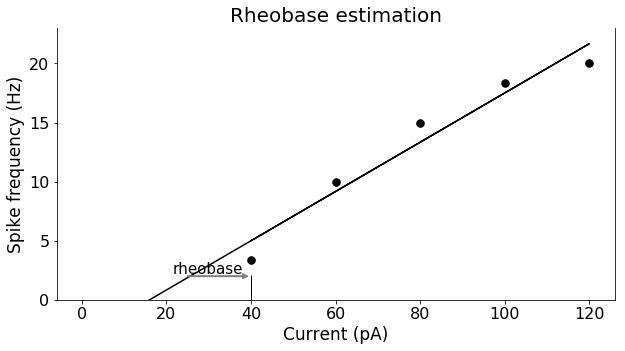

In [433]:
Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)

In [434]:
Cell_Features

,Resting membrane potential (mV),Input resistance (MOhm),Membrane time constant (ms),AP threshold (mV),AP amplitude (mV),AP width (ms),Upstroke-to-downstroke ratio,Afterhyperpolarization (mV),Afterdepolarization (mV),ISI adaptation index,...,Rebound (mV),Sag time (s),Sag area (mV*s),AP amplitude adaptation index,AP amplitude average adaptation index,AP Fano factor,AP coefficient of variation,Burstiness,Wildness,Rebound number of APs
0,-60.010632,223.541143,6.70116,-29.101875,83.430894,1.12,2.97087,-12.193035,0.750449,3.468828,...,1.828928,0.22,20.554008,0.815874,0.999238,1.577884,0.145242,0.315888,19.0,0


In [7]:
def cell_features(data_tuple, names, el_num = 2, current_step = 20):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)
        plt.close()
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features], sort = True)
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features

In [8]:
# If you want all the features in one go with your .nwb files
def cell_features_nwb(data_tuple_nwb, names_nwb):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple_nwb : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names_nwb : tuple of names of the samples
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, name) in zip(data_tuple_nwb, names_nwb):
        print('Processing: ', name)
        time, voltage, current, curr_index_0 = get_time_voltage_current_currindex0(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)
        plt.close()
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features], sort = True)
    All_Cells_Features.insert(0, 'name sample', names_nwb)
    return All_Cells_Features

In [56]:
# Extracting data and saving the features of every cell in an excel file for M1 .mat files
All_Cells_Features_M1 = cell_features(M1_rev[:2], M1_rev_names[:2])

Processing:  ../M1_revision/data/04 07 2020 sample 19.mat
Processing:  ../M1_revision/data/04 03 2020 sample 6.mat


In [26]:
# Extracting data and saving the features of every cell in an excel file for M1 .mat files
All_Cells_Features_M1 = cell_features_nwb(M1_nwb, M1_nwb_names)

Processing:  ../M1/NWBData/20180403_sample_5.nwb
Processing:  ../M1/NWBData/20190627_sample_8.nwb
Processing:  ../M1/NWBData/20190719_sample_1.nwb
Processing:  ../M1/NWBData/20190501_sample_4.nwb
Processing:  ../M1/NWBData/20190516_sample_3.nwb
Processing:  ../M1/NWBData/20190722_sample_7.nwb
Processing:  ../M1/NWBData/20190204_sample_7.nwb
Processing:  ../M1/NWBData/20191104_sample_3.nwb
Processing:  ../M1/NWBData/20191107_sample_2.nwb
Processing:  ../M1/NWBData/20190403_sample_5.nwb
Processing:  ../M1/NWBData/20180413_sample_2.nwb
Processing:  ../M1/NWBData/20180817_sample_3.nwb
Processing:  ../M1/NWBData/20190625_sample_12.nwb
Processing:  ../M1/NWBData/20180829_sample_5.nwb
Processing:  ../M1/NWBData/20190820_sample_1.nwb
Processing:  ../M1/NWBData/20181213_sample_4.nwb
Processing:  ../M1/NWBData/20190624_sample_3.nwb
Processing:  ../M1/NWBData/20190724_sample_6.nwb
Processing:  ../M1/NWBData/20180417_sample_2.nwb
Processing:  ../M1/NWBData/20190322_sample_4.nwb
Processing:  ../M1/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:248: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../M1/NWBData/20190423_sample_1.nwb
Processing:  ../M1/NWBData/20190613_sample_10.nwb
Processing:  ../M1/NWBData/20190325_sample_4.nwb
Processing:  ../M1/NWBData/20180104_sample_4.nwb
Processing:  ../M1/NWBData/20180704_sample_3.nwb
Processing:  ../M1/NWBData/20180704_sample_2.nwb
Processing:  ../M1/NWBData/20190403_sample_7.nwb
Processing:  ../M1/NWBData/20191107_sample_3.nwb
Processing:  ../M1/NWBData/20180920_sample_1.nwb
Processing:  ../M1/NWBData/20191114_sample_7.nwb
Processing:  ../M1/NWBData/20180718_sample_3.nwb
Processing:  ../M1/NWBData/20190221_sample_11.nwb
Processing:  ../M1/NWBData/20180829_sample_1.nwb
Processing:  ../M1/NWBData/20180110_sample_4.nwb
Processing:  ../M1/NWBData/20181003_sample_10.nwb
Processing:  ../M1/NWBData/20180410_sample_3.nwb
Processing:  ../M1/NWBData/20190516_sample_4.nwb
Processing:  ../M1/NWBData/20190329_sample_3.nwb
Processing:  ../M1/NWBData/20190501_sample_11.nwb
Processing:  ../M1/NWBData/20190604_sample_4.nwb
Processing:  ../

Processing:  ../M1/NWBData/20190618_sample_7.nwb
Processing:  ../M1/NWBData/20190729_sample_5.nwb
Processing:  ../M1/NWBData/20180911_sample_5.nwb
Processing:  ../M1/NWBData/20181121_sample_7.nwb
Processing:  ../M1/NWBData/20180315_sample_6.nwb
Processing:  ../M1/NWBData/20180109_sample_5.nwb
Processing:  ../M1/NWBData/20190709_sample_12.nwb
Processing:  ../M1/NWBData/20190424_sample_3.nwb
Processing:  ../M1/NWBData/20180109_sample_1.nwb
Processing:  ../M1/NWBData/20190605_sample_2.nwb
Processing:  ../M1/NWBData/20180712_sample_11.nwb
Processing:  ../M1/NWBData/20180910_sample_3.nwb
Processing:  ../M1/NWBData/20190821_sample_4.nwb
Processing:  ../M1/NWBData/20180502_sample_2.nwb
Processing:  ../M1/NWBData/20181003_sample_6.nwb
Processing:  ../M1/NWBData/20190625_sample_7.nwb
Processing:  ../M1/NWBData/20190620_sample_2.nwb
Processing:  ../M1/NWBData/20190219_sample_7.nwb
Processing:  ../M1/NWBData/20180110_sample_8.nwb
Processing:  ../M1/NWBData/20190204_sample_21.nwb
Processing:  ../M

Processing:  ../M1/NWBData/20190430_sample_3.nwb
Processing:  ../M1/NWBData/20181207_sample_6.nwb
Processing:  ../M1/NWBData/20190910_sample_6.nwb
Processing:  ../M1/NWBData/20190708_sample_4.nwb
Processing:  ../M1/NWBData/20180110_sample_3.nwb
Processing:  ../M1/NWBData/20180904_sample_1.nwb
Processing:  ../M1/NWBData/20190606_sample_3.nwb
Processing:  ../M1/NWBData/20190508_sample_6.nwb
Processing:  ../M1/NWBData/20190725_sample_10.nwb
Processing:  ../M1/NWBData/20180405_sample_2.nwb
Processing:  ../M1/NWBData/20181213_sample_2.nwb
Processing:  ../M1/NWBData/20190717_sample_2.nwb
Processing:  ../M1/NWBData/20190912_sample_2.nwb
Processing:  ../M1/NWBData/20180103_sample_2.nwb
Processing:  ../M1/NWBData/20190910_sample_2.nwb
Processing:  ../M1/NWBData/20180420_sample_2.nwb
Processing:  ../M1/NWBData/20190625_sample_5.nwb
Processing:  ../M1/NWBData/20190705_sample_1.nwb
Processing:  ../M1/NWBData/20190709_sample_11.nwb
Processing:  ../M1/NWBData/20190731_sample_3.nwb
Processing:  ../M1

Processing:  ../M1/NWBData/20181010_sample_8.nwb
Processing:  ../M1/NWBData/20180103_sample_8.nwb
Processing:  ../M1/NWBData/20181214_sample_1.nwb
Processing:  ../M1/NWBData/20190905_sample_3.nwb
Processing:  ../M1/NWBData/20190725_sample_5.nwb
Processing:  ../M1/NWBData/20180105_sample_4.nwb
Processing:  ../M1/NWBData/20190213_sample_8.nwb
Processing:  ../M1/NWBData/20190709_sample_10.nwb
Processing:  ../M1/NWBData/20181002_sample_7.nwb
Processing:  ../M1/NWBData/20190704_sample_2.nwb
Processing:  ../M1/NWBData/20181208_sample_3.nwb
Processing:  ../M1/NWBData/20190603_sample_3.nwb
Processing:  ../M1/NWBData/20190424_sample_6.nwb
Processing:  ../M1/NWBData/20190716_sample_3.nwb
Processing:  ../M1/NWBData/20180225_sample_1.nwb
Processing:  ../M1/NWBData/20180828_sample_4.nwb
Processing:  ../M1/NWBData/20190425_sample_14.nwb
Processing:  ../M1/NWBData/20180404_sample_1.nwb
Processing:  ../M1/NWBData/20180726_sample_5.nwb
Processing:  ../M1/NWBData/20190919_sample_5.nwb
Processing:  ../M1

Processing:  ../M1/NWBData/20190612_sample_7.nwb
Processing:  ../M1/NWBData/20190108_sample_5.nwb
Processing:  ../M1/NWBData/20181002_sample_6.nwb
Processing:  ../M1/NWBData/20190827_sample_8.nwb
Processing:  ../M1/NWBData/20180927_sample_2.nwb
Processing:  ../M1/NWBData/20190715_sample_10.nwb
Processing:  ../M1/NWBData/20190415_sample_10.nwb
Processing:  ../M1/NWBData/20190625_sample_13.nwb
Processing:  ../M1/NWBData/20190326_sample_1.nwb
Processing:  ../M1/NWBData/20181203_sample_8.nwb
Processing:  ../M1/NWBData/20190620_sample_6.nwb
Processing:  ../M1/NWBData/20190422_sample_8.nwb
Processing:  ../M1/NWBData/20190719_sample_9.nwb
Processing:  ../M1/NWBData/20180411_sample_3.nwb
Processing:  ../M1/NWBData/20180628_sample_3.nwb
Processing:  ../M1/NWBData/20190614_sample_8.nwb
Processing:  ../M1/NWBData/20180828_sample_7.nwb
Processing:  ../M1/NWBData/20190628_sample_3.nwb
Processing:  ../M1/NWBData/20190604_sample_6.nwb
Processing:  ../M1/NWBData/20190603_sample_1.nwb
Processing:  ../M

Processing:  ../M1/NWBData/20190508_sample_3.nwb
Processing:  ../M1/NWBData/20180329_sample_7.nwb
Processing:  ../M1/NWBData/20180104_sample_3.nwb
Processing:  ../M1/NWBData/20190611_sample_4.nwb
Processing:  ../M1/NWBData/20190620_sample_1.nwb
Processing:  ../M1/NWBData/20180103_sample_5.nwb
Processing:  ../M1/NWBData/20181004_sample_5.nwb
Processing:  ../M1/NWBData/20190204_sample_4.nwb
Processing:  ../M1/NWBData/20190201_sample_7.nwb
Processing:  ../M1/NWBData/20190612_sample_4.nwb
Processing:  ../M1/NWBData/20190501_sample_14.nwb
Processing:  ../M1/NWBData/20190515_sample_3.nwb
Processing:  ../M1/NWBData/20190725_sample_1.nwb
Processing:  ../M1/NWBData/20180104_sample_1.nwb
Processing:  ../M1/NWBData/20190603_sample_4.nwb
Processing:  ../M1/NWBData/20190425_sample_6.nwb
Processing:  ../M1/NWBData/20180820_sample_2.nwb
Processing:  ../M1/NWBData/20180410_sample_9.nwb
Processing:  ../M1/NWBData/20190904_sample_3.nwb
Processing:  ../M1/NWBData/20190603_sample_9.nwb
Processing:  ../M1/

Processing:  ../M1/NWBData/20190430_sample_4.nwb
Processing:  ../M1/NWBData/20190607_sample_2.nwb
Processing:  ../M1/NWBData/20190410_sample_3.nwb
Processing:  ../M1/NWBData/20191028_sample_2.nwb
Processing:  ../M1/NWBData/20180420_sample_3.nwb
Processing:  ../M1/NWBData/20181205_sample_1.nwb
Processing:  ../M1/NWBData/20190423_sample_5.nwb
Processing:  ../M1/NWBData/20180424_sample_1.nwb
Processing:  ../M1/NWBData/20180108_sample_10.nwb
Processing:  ../M1/NWBData/20180720_sample_2.nwb
Processing:  ../M1/NWBData/20190731_sample_4.nwb
Processing:  ../M1/NWBData/20190718_sample_8.nwb
Processing:  ../M1/NWBData/20171219_sample_4.nwb
Processing:  ../M1/NWBData/20190409_sample_5.nwb
Processing:  ../M1/NWBData/20180208_sample_4.nwb
Processing:  ../M1/NWBData/20180822_sample_1.nwb
Processing:  ../M1/NWBData/20190506_sample_1.nwb
Processing:  ../M1/NWBData/20190726_sample_2.nwb
Processing:  ../M1/NWBData/20190715_sample_1.nwb
Processing:  ../M1/NWBData/20180118_sample_4.nwb
Processing:  ../M1/

Processing:  ../M1/NWBData/20190705_sample_9.nwb
Processing:  ../M1/NWBData/20180417_sample_9.nwb
Processing:  ../M1/NWBData/20180918_sample_2.nwb
Processing:  ../M1/NWBData/20181126_sample_6.nwb
Processing:  ../M1/NWBData/20190614_sample_2.nwb
Processing:  ../M1/NWBData/20190214_sample_1.nwb
Processing:  ../M1/NWBData/20180502_sample_1.nwb
Processing:  ../M1/NWBData/20190402_sample_5.nwb
Processing:  ../M1/NWBData/20190325_sample_9.nwb
Processing:  ../M1/NWBData/20190318_sample_3.nwb
Processing:  ../M1/NWBData/20190726_sample_1.nwb
Processing:  ../M1/NWBData/20190912_sample_6.nwb
Processing:  ../M1/NWBData/20191010_sample_6.nwb
Processing:  ../M1/NWBData/20180509_sample_9.nwb
Processing:  ../M1/NWBData/20190429_sample_4.nwb
Processing:  ../M1/NWBData/20190801_sample_2.nwb
Processing:  ../M1/NWBData/20181116_sample_3.nwb
Processing:  ../M1/NWBData/20180820_sample_1.nwb


In [57]:
cells_w_ephys=['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
                                      g.split('/')[-1].split(' ')[1], '_sample_', \
                                      g.split('/')[-1].split(' ')[-1].split('.')[0]) \
                   for g in All_Cells_Features_M1['name sample']]
All_Cells_Features_M1['cell id']=cells_w_ephys
All_Cells_Features_M1=All_Cells_Features_M1.set_index('cell id')
All_Cells_Features_M1=All_Cells_Features_M1.drop('name sample', axis=1)

In [31]:
All_Cells_Features_M1.to_csv('../M1/Analysis/M1Data/Cell_Features_M1.csv')

In [49]:
All_Cells_Features_M1.to_csv('../M1_revision/analysis/Cell_Features_M1_revision.csv')

In [45]:
##Was necessary at some point to move certain neurons from one dataframe to another

# data_rev=pd.read_csv('../M1_revision/analysis/Cell_Features_M1_revision.csv')
# data_rev=data_rev.drop('Unnamed: 0', axis=1)
# data_rev=data_rev.set_index('name sample')
# cells_w_ephys = ['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
#                                      g.split('/')[-1].split(' ')[1], '_sample_', \
#                                      g.split('/')[-1].split(' ')[-1].split('.')[0]) \
#                   for g in list(data_rev.index)]
# data_rev['name_sample']=cells_w_ephys
# data_rev=data_rev.set_index('name_sample')
# data=pd.read_csv('../M1/Analysis/M1Data/Cell_Features_M1_3_latencies.csv')
# data=data.drop('Unnamed: 0', axis=1)
# data=data.set_index('name sample')
# cells_w_ephys = ['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
#                                      g.split('/')[-1].split(' ')[1], '_sample_', \
#                                      g.split('/')[-1].split(' ')[-1].split('.')[0]) \
#                   for g in list(data.index)]
# data['name_sample']=cells_w_ephys
# data=data.set_index('name_sample')
# new_samples=['20200106_sample_1', '20200106_sample_4', '20200106_sample_5', '20200106_sample_6', \
#              '20200225_sample_2', '20200225_sample_5', '20200316_sample_1', '20200316_sample_1', \
#              '20200316_sample_2', '20200316_sample_3']
# data=pd.concat([data, data_rev.loc[new_samples, :]])
# data_rev=data_rev.drop(new_samples)
# data.to_csv('../M1/Analysis/M1Data/Cell_Features_M1_3_latencies.csv')
# data_rev.to_csv('../M1_revision/analysis/Cell_Features_M1_revision.csv')

# Plotting information as sanity check

In [59]:
def prel_inspection(data, axis = None):
    """ Plots the voltage traces for some current steps ment for quality checks and preliminary inspection
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    axis : axis you'd like to plot information on (optional, None by default)
        
    Returns
    -------
    ax : figure object
    
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 10))
    grey_colors = np.array([[0, 0, 0], [49, 79, 79], [105, 105, 105], [112, 138, 144], [119, 136, 153], [190, 190, 190], \
                   [211, 211, 211]]) / 256
    for i in np.arange(0, voltage.shape[1], 1):
        if time[-1] < 0.9:
            ax.plot(time, voltage, color=grey_colors[np.random.randint(0,6)])
        else:
            ax.plot(time[:ft.find_time_index(time, 0.9)], voltage[:ft.find_time_index(time, 0.9), i], \
                    color = grey_colors[np.random.randint(0, 6)])
    ax.set_title('All traces', fontsize = 20)
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    
    return ax

In [13]:
def prel_inspection_all(data_tuple, names, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        ax = prel_inspection(data)
        ax.set_title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [14]:
prel_inspection_all(M1, M1_names, '../M1/Figures/PrelInspection/')

Processing:  ../M1/2018/sept/09 18 2018/09 18 2018 sample 1.mat
Processing:  ../M1/2018/sept/09 18 2018/09 18 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 18 2018/09 18 2018 sample 3.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 4.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 1.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 5.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 3.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 1.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 6.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 3.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 5.mat
Processing:  ../M1/2018/sept/09 05 2018/09 05 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 05 2018/09 05 2018 sample 1.mat
Processing:  ../M1/2018/sept/09 10 2018/

Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 4.mat
Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 1.mat
Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 2.mat
Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 3.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 4.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 1.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 3.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 6.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 5.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 2.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 7.mat
Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 2.mat
Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 3.mat
Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 1.mat
Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 4.mat
Processing:  ../M1/2018/may/05 29 2018/05 29 2018 sampl

Processing:  ../M1/2018/Oct/10 03 2018/10 03 2018 sample 4.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 4.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 10.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 6.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 5.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 8.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 1.mat
Processing:  ../M1/2018/Oct/10 10 2018/10 10 2018 sample 3.mat
Processing:  ../M1/2018/Oct/10 04 2018/10 04 2018 sample 8.mat
Processing:  ../M1/2018/Oct/10 04 2018/10 04 2018 sample 5.mat
Processing:  ../M1/2018/Oct/10 04 2018/10 04 2018 sample 6.mat
Processing:  ../M1/2018/Oct/10 04 2018/10 04 2018 sample 3.mat
Processing:  ../M1/2018/Oct/10 04 2018/10 04 2018 sample 1.mat
Processing:  ../M1/2018/Oct/10 02 2018/10 02 2018 sample 8.mat
Processing:  ../M1/2018/Oct/10 02 2018/10 02 2018 sample 5.mat
Processing:  ../M1/2018/Oct/10 02 2018/10 02 2018 samp

Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat
Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat
Processing:  ../M1/2018/feb/02 25 2018/02 25 2018 sample 1.mat
Processing:  ../M1/2018/feb/02 25 2018/02 25 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 25 2018/02 25 2018 sample 2.mat
Processing:  ../M1/2018/feb/02 25 2018/02 25 2018 sample 4.mat
Processing:  ../M1/2018/feb/02 25 2018/02 25 2018 sample 3.mat
Processing:  ../M1/2018/feb/02 25 2018/02 25 2018 sample 7.mat
Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat
Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat
Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat
Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sampl

Processing:  ../M1/2019/feb/02 04 2019/02 04 2019 sample 2.mat
Processing:  ../M1/2019/feb/02 04 2019/02 04 2019 sample 4.mat
Processing:  ../M1/2019/feb/02 04 2019/02 04 2019 sample 9.mat
Processing:  ../M1/2017/Dec/12 04 2017/12 04 2017 sample 2.mat
Processing:  ../M1/2017/Dec/12 04 2017/12 04 2017 sample 4.mat
Processing:  ../M1/2017/Dec/12 04 2017/12 04 2017 sample 5.mat
Processing:  ../M1/2017/Dec/12 04 2017/12 04 2017 sample 6.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 7.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat
Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


In [14]:
def three_informative_traces(data, el_num = 2, current_step = 20, start = 0.1, end = 0.7, axis = None, per_type = False):
    """ Plots the voltage traces for the steepest hyperpolarisation trace, the first trace that shows spikes and the highest
    frequency trace.
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of stimulation interval (s, optional)
    end : end of stimulation interval (s, optional)
    axis : axis you'd like to plot information on (optional, None by default)
    per_type : plot less info if True (optional, False by default)
        
    Returns
    -------
    ax : figure object
    
    """
    time, current, voltage, curr_index_0 = data_preparation(data, el_num = 2, current_step = 20)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    # Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    # plt.close()
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # one spikes
    index_df =  np.where(df.loc[0]['fast_trough_i'].values[~np.isnan(df.loc[0]['fast_trough_i'].values)] > 0)[0][0]
    current_first = np.where(current == df.loc[0]['fast_trough_i'].values[index_df])[0][0]
    # The max amount of spikes in 600 ms of the trace showing the max amount of spikes in 600 ms
    max_freq = np.max(df_related_features['spike_count'].values)
    # Take the first trace showing this many spikes if there are many
    current_max_freq = np.flatnonzero(df_related_features['spike_count'].values >= max_freq)[0]
    
    # Check if there are peaks outside the stimilation interval for the highest firing trace. When true, continue looking
    # for lower firing traces untill it shows none anymore.
    artifact_occurence = False
    EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                  v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                  i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                  start = end, end = time[-1])
    EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)], \
                                                  v = voltage[:ft.find_time_index(time, start), current_max_freq], \
                                                  i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                  start = 0, end = start - (time[1] - time[0]))
    EphysObject_end.process_spikes()
    EphysObject_start.process_spikes()
    if EphysObject_end._spikes_df.size or EphysObject_start._spikes_df.size:
                artifact_occurence = True
    while artifact_occurence:
        current_max_freq-=1
        
        EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                  v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                  i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                  start = end, end = time[-1])
        EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)], \
                                                  v = voltage[:ft.find_time_index(time, start), current_max_freq], \
                                                  i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                  start = 0, end = start - (time[1] - time[0]))
        EphysObject_end.process_spikes()
        EphysObject_start.process_spikes()
        if not EphysObject_end._spikes_df.size and not EphysObject_start._spikes_df.size:
            artifact_occurence = False

    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 10))
    
    grey_colors = np.array([[0, 0, 0], [49, 79, 79], [105, 105, 105]]) / 256
    ax.plot(time, voltage[:, 0], color = grey_colors[0], linewidth = 2.5)
    ax.plot(time, voltage[:, current_first], color = grey_colors[1], linewidth = 2.5)
    ax.plot(time[ft.find_time_index(time, 0.1):ft.find_time_index(time, 0.7)], \
            voltage[ft.find_time_index(time, 0.1):ft.find_time_index(time, 0.7), current_max_freq] + 100, \
            color = grey_colors[2], linewidth = 2.5)
    ax.set_ylim([-150, 210])
    
    #if np.sum(df_related_features['spike_count'] == max_freq) % 2 != 0: # The median will be a Fano_factor and cv
    #                                                                        # in the DataFrame
    #            fano_factor = np.nanmedian(df_related_features.loc[df_related_features['spike_count'] == max_freq, \
    #                                                               'fano_factor'])
    #else: # Just take the first trace showing the max # number of spikes in 600 ms
    #            fano_factor = df_related_features.loc[df_related_features['spike_count'] == max_freq, \
    #                                                  'fano_factor'].values[0]

    if not per_type:
        ax.set_title('Three traces', fontsize = 20)
        ax.set_xlabel('Time (s)', fontsize = 17)
        ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    else:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        sns.despine(ax = ax, left = True, bottom = True)
        #plt.xticks([])
        #plt.yticks([])
    return ax

In [15]:
def three_informative_traces_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data, el_num = el_num, current_step = current_step)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        ax = three_informative_traces(data, el_num = el_num, current_step = current_step)
        plt.title(name, fontsize = 25)
        plt.savefig('{}png files/{}.png'.format(directory, name), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.savefig('{}pdf files/{}.pdf'.format(directory, name), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [16]:
def three_informative_traces_per_type(data_tuple, names, directory, cellTypes, cellType_Labels,\
                                      el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    cellTypes : list of numbers corresponding to different celltypes, as long as names and data_tuple
    cellType_Labels : dictionary of numbers corresponding to celltypes
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory, all 3 traces for each neuron of a certain type in one .png file
    """
    import math
    for c in np.unique(cellTypes)[1:]:
        print('Type: ', cellType_Labels[c])
        data_tuple_ = np.array(data_tuple)[cellTypes==c]
        names_ = np.array(names)[cellTypes==c]
        amount_of_subplots = sum(cellTypes==c)
        columns = 6
        # Make a x times columns subplot figure (6 plots per row), x = ceil(amount_of_subplots/columns) 
        rows = math.ceil(amount_of_subplots / columns)
        fig, axes = plt.subplots(rows, columns, figsize = (12, rows*2))
        
        for (data, name, ax) in zip(data_tuple_, names_, axes.reshape(-1)):
            print('Processing: ', name)
            time, current, voltage, curr_index_0 = data_preparation(data, el_num = el_num, current_step = current_step)
            filter_ = 10
            if (1/time[1]-time[0]) < 20e3:
                filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
            three_informative_traces(data, el_num = el_num, current_step = current_step, axis = ax, per_type = True)
            ax.set_title(name, fontsize = 4)
        for ax in axes.reshape(-1)[len(data_tuple_):]:     # Make all other plots completely white
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            sns.despine(ax = ax, left = True, bottom = True)
        fig.suptitle(cellType_Labels[c], y = 1, fontsize = 9)
        plt.tight_layout()
        plt.savefig('{}/{}.png'.format(directory, cellType_Labels[c]), dpi = 200)
        

In [63]:
# # Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
# prop = pd.read_excel('../M1/Analysis/M1Data/M1 DNA + morphology List.xlsx', sheet_name = 'MOp patchseq+ morphology')
# prop = prop.rename(columns = {'Date': 'date', 'Sample': 'sample_id', 'Layer': 'Layer'})
# prop = prop[['date', 'sample_id', 'Layer', 'Cre', 'RNA class', 'RNA type top-3']]
# sample_name = ['{}{}{}{}{}'.format(g.split(' ')[2][:4], g.split(' ')[0], g.split(' ')[1], \
#                                    'sample', g.split(' ')[-1]) \
#                for g in (prop['date'].map(str.strip) + prop['sample_id'].map(str.strip)).tolist()]
# prop['sample name'] = sample_name
# prop = prop.set_index('sample name')

# prop = prop.reindex(new_names) # There could be more cells with ephys than manually labelled
#                                     # They will receive the Nan property
# prop = prop.fillna('')
# M1_Allen_Mapping = np.array([g.split(',')[0].split('(')[0][:-1] if ',' in g else g.split('(')[0][:-1] \
#                              for g in prop['RNA type top-3']])
# M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
# number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
# cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])
# for i, c in enumerate(np.unique(M1_Allen_Mapping)):
#     cellTypes[np.array(M1_Allen_Mapping) == c] = i
# cellTypeLabels = dict(zip(range(0,int(np.max(cellTypes)) + 1), np.unique(M1_Allen_Mapping)))
# cellTypeLabels[0] = 'low quality'

# # We need to change a couple of names a bit, for directory and saving purposes of .png files
# for i in cellTypeLabels:
#     if cellTypeLabels[i] == 'L2/3 IT_2':
#         cellTypeLabels[i] = 'L2_3 IT_2'
#     if cellTypeLabels[i] == 'L2/3 IT_3':
#         cellTypeLabels[i] = 'L2_3 IT_3'
#     if cellTypeLabels[i] == 'L5/6 NP_1':
#         cellTypeLabels[i] = 'L5_6 NP_1'
#     if cellTypeLabels[i] == 'L5/6 NP_2':
#         cellTypeLabels[i] = 'L5_6 NP_2'
#     if cellTypeLabels[i] == 'L5/6 NP_3':
#         cellTypeLabels[i] = 'L5_6 NP_3'
#     if cellTypeLabels[i] == 'L6/6 NP CT':
#         cellTypeLabels[i] = 'L6_6 NP CT'
#     if cellTypeLabels[i] == 'L5/6 NP CT':
#         cellTypeLabels[i] = 'L5_6 NP CT'

In [64]:
# # You should pass this new new_names list to three_informative_traces_all so that your filenames are nice
# import seaborn as sns
# sns.set_style('white')
# three_informative_traces_per_type(M1, new_names, '../M1/Figures/ThreeInformativeTraces/PerRNAType/', \
#                                  cellTypes, cellTypeLabels)

In [65]:
# # You should pass this new new_names list to three_informative_traces_all so that your filenames are nice
# directory = '../M1/Figures/ThreeInformativeTraces/'
# import seaborn as sns
# sns.set_style('white')
# three_informative_traces_all(M1, new_names, directory)

In [18]:
def save_three_informative_traces(data_tuple, names, el_num = 2, current_step = 20, start = 0.1, end = 0.7):
    """ Saves a dictionary in a .pickle file with the three voltage traces and the time trace for every neuron in the 
    data list. It should be easy to use for others to quickly plot this in a bigger figure.
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of stimulation interval (s, optional)
    end : end of stimulation interval (s, optional)
        
    Returns
    -------
    three_traces : pickle object
    
    """
    voltage_time_list = []
    for data, name in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data, el_num = 2, current_step = 20)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    
        # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
        # one spikes
        index_df =  np.where(df.loc[0]['fast_trough_i'].values[~np.isnan(df.loc[0]['fast_trough_i'].values)] > 0)[0][0]
        current_first = np.where(current == df.loc[0]['fast_trough_i'].values[index_df])[0][0]
        
        # The max amount of spikes in 600 ms of the trace showing the max amount of spikes in 600 ms
        max_freq = np.max(df_related_features['spike_count'].values)
        # Take the first trace showing this many spikes if there are many
        current_max_freq = np.flatnonzero(df_related_features['spike_count'].values >= max_freq)[0]
        # Check if there are peaks outside the stimilation interval for the highest firing trace. When true, continue looking
        # for lower firing traces untill it shows none anymore.
        artifact_occurence = False
        EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                  v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                  i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                  start = end, end = time[-1])
        EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)], \
                                                      v = voltage[:ft.find_time_index(time, start), current_max_freq], \
                                                      i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                      start = 0, end = start - (time[1] - time[0]))
        EphysObject_end.process_spikes()
        EphysObject_start.process_spikes()
        if EphysObject_end._spikes_df.size or EphysObject_start._spikes_df.size:
                    artifact_occurence = True
        while artifact_occurence:
            current_max_freq-=1

            EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                      v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                      i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                      start = end, end = time[-1])
            EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)], \
                                                      v = voltage[:ft.find_time_index(time, start), current_max_freq], \
                                                      i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                      start = 0, end = start - (time[1] - time[0]))
            EphysObject_end.process_spikes()
            EphysObject_start.process_spikes()
            if not EphysObject_end._spikes_df.size and not EphysObject_start._spikes_df.size:
                artifact_occurence = False
        matrix = np.concatenate((voltage[:, [0, current_first, current_max_freq]], time[:, np.newaxis]), axis = 1)
        voltage_time_list.append(matrix)
    return {name: mat for name, mat in zip(names, voltage_time_list)}

In [ ]:
cells_w_ephys=['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
                                      g.split('/')[-1].split(' ')[1], '_sample_', \
                                      g.split('/')[-1].split(' ')[-1].split('.')[0]) \
                   for g in M1_names]

In [32]:
three_traces = save_three_informative_traces(M1, cells_w_ephys)

Processing:  20180918_sample_1
Processing:  20180918_sample_2
Processing:  20180918_sample_3
Processing:  20180917_sample_4
Processing:  20180917_sample_1
Processing:  20180917_sample_2
Processing:  20180917_sample_5
Processing:  20180917_sample_3
Processing:  20180911_sample_1
Processing:  20180911_sample_6
Processing:  20180911_sample_2
Processing:  20180911_sample_3
Processing:  20180911_sample_5
Processing:  20180905_sample_2
Processing:  20180905_sample_1
Processing:  20180910_sample_2
Processing:  20180910_sample_3
Processing:  20180925_sample_9
Processing:  20180926_sample_3
Processing:  20180926_sample_9
Processing:  20180926_sample_7
Processing:  20180926_sample_4
Processing:  20180926_sample_1
Processing:  20180913_sample_2
Processing:  20180927_sample_4
Processing:  20180927_sample_9
Processing:  20180927_sample_3
Processing:  20180927_sample_5
Processing:  20180927_sample_1
Processing:  20180927_sample_10
Processing:  20180927_sample_7
Processing:  20180927_sample_2
Process

Processing:  20180108_sample_5
Processing:  20180108_sample_1
Processing:  20180108_sample_3
Processing:  20180103_sample_3
Processing:  20180103_sample_7
Processing:  20180103_sample_6
Processing:  20180103_sample_2
Processing:  20180103_sample_5
Processing:  20180103_sample_4
Processing:  20180103_sample_1
Processing:  20180103_sample_8
Processing:  20180123_sample_7
Processing:  20180123_sample_3
Processing:  20180123_sample_5
Processing:  20180123_sample_1
Processing:  20180123_sample_6
Processing:  20180102_sample_3
Processing:  20180102_sample_4
Processing:  20180102_sample_2
Processing:  20180102_sample_5
Processing:  20180102_sample_1
Processing:  20180118_sample_7
Processing:  20180118_sample_10
Processing:  20180118_sample_4
Processing:  20180118_sample_1
Processing:  20180118_sample_6
Processing:  20180118_sample_2
Processing:  20181011_sample_3
Processing:  20181011_sample_10
Processing:  20181011_sample_9
Processing:  20181011_sample_4
Processing:  20181011_sample_8
Proces

Processing:  20190924_sample_1
Processing:  20190924_sample_8
Processing:  20190924_sample_5
Processing:  20190924_sample_4
Processing:  20190919_sample_1
Processing:  20190919_sample_4
Processing:  20190919_sample_5
Processing:  20190926_sample_2
Processing:  20190926_sample_6
Processing:  20190926_sample_4
Processing:  20190926_sample_3
Processing:  20190926_sample_5
Processing:  20190925_sample_2
Processing:  20190925_sample_7
Processing:  20190925_sample_5
Processing:  20190925_sample_4
Processing:  20190925_sample_6
Processing:  20190925_sample_3
Processing:  20190917_sample_1
Processing:  20190917_sample_3
Processing:  20190917_sample_2
Processing:  20190910_sample_4
Processing:  20190910_sample_2
Processing:  20190910_sample_3
Processing:  20190910_sample_1
Processing:  20190910_sample_6
Processing:  20190906_sample_1
Processing:  20190906_sample_6
Processing:  20190906_sample_5
Processing:  20190912_sample_1
Processing:  20190912_sample_6
Processing:  20190912_sample_4
Processi

Processing:  20191107_sample_4
Processing:  20191114_sample_3
Processing:  20191114_sample_8
Processing:  20191114_sample_7
Processing:  20191114_sample_5
Processing:  20191114_sample_2
Processing:  20191114_sample_4
Processing:  20191114_sample_1
Processing:  20191114_sample_9
Processing:  20191106_sample_2
Processing:  20191106_sample_5
Processing:  20191106_sample_3
Processing:  20191105_sample_4
Processing:  20191105_sample_1
Processing:  20191105_sample_2
Processing:  20191105_sample_5
Processing:  20191105_sample_3
Processing:  20190122_sample_10
Processing:  20190122_sample_1
Processing:  20190122_sample_16
Processing:  20190122_sample_6
Processing:  20190122_sample_9
Processing:  20190122_sample_14
Processing:  20190122_sample_5
Processing:  20190122_sample_13
Processing:  20190122_sample_3
Processing:  20190122_sample_2
Processing:  20190122_sample_17
Processing:  20190122_sample_11
Processing:  20190122_sample_12
Processing:  20190124_sample_4
Processing:  20190131_sample_1
P

Processing:  20190820_sample_6
Processing:  20190820_sample_2
Processing:  20190820_sample_5
Processing:  20190820_sample_3
Processing:  20190801_sample_7
Processing:  20190801_sample_4
Processing:  20190801_sample_2
Processing:  20190801_sample_8
Processing:  20190801_sample_1
Processing:  20190801_sample_3
Processing:  20190409_sample_11
Processing:  20190409_sample_9
Processing:  20190409_sample_2
Processing:  20190409_sample_8
Processing:  20190409_sample_10
Processing:  20190409_sample_3
Processing:  20190409_sample_7
Processing:  20190409_sample_5
Processing:  20190409_sample_4
Processing:  20190412_sample_6
Processing:  20190412_sample_1
Processing:  20190412_sample_3
Processing:  20190410_sample_7
Processing:  20190410_sample_6
Processing:  20190410_sample_4
Processing:  20190410_sample_10
Processing:  20190410_sample_3
Processing:  20190416_sample_4
Processing:  20190416_sample_10
Processing:  20190416_sample_6
Processing:  20190416_sample_9
Processing:  20190416_sample_7
Proc

Processing:  20200106_sample_4
Processing:  20200106_sample_1
Processing:  20200225_sample_2
Processing:  20200225_sample_5
Processing:  20200316_sample_3
Processing:  20200316_sample_2
Processing:  20200316_sample_1


In [33]:
import pickle
with open('three_traces.pickle', 'wb') as f:
    pickle.dump(three_traces, f)

In [232]:
import pickle 
with open('three_traces.pickle', 'rb') as f:
    three_traces = pickle.load(f)

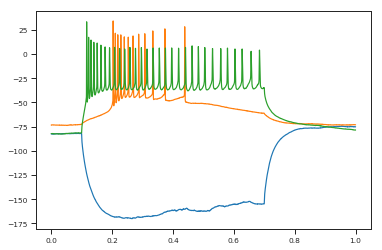

In [233]:
mat = three_traces['20181213sample7']
plt.plot(mat[:, 3], mat[:, :3])

In [68]:
def plot_info(data, el_num = 2, current_step = 20, start = 0.1, end = 0.7, axis = None):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data, el_num = 2, current_step = 20)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)
    plt.close()
    
    if not np.any(df_related_features['spike_count'].values > 3):
        return
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 10))
    
    if time[-1] < 0.9:
        ax.plot(time, voltage[:,current_first], color=np.array([0,0,0]))
    else:
        ax.plot(time[:ft.find_time_index(time, 0.9)], voltage[:ft.find_time_index(time, 0.9), current_first], \
                    color = np.array([0,0,0]))
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    #ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15, label = None)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15, label = 'AP threshold')
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15, label = 'AP upstroke')
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15, label = 'AP peak')
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15, label = 'AP downstroke')
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15, label = 'AP fast trough')
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15, \
            label = 'AP slow trough\n(if applicable)')
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.set_title('First trace showing at least three APs', fontsize = 20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    #ax.legend(['Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
    #           'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    ax.legend(fontsize = 15, loc = 'upper right')
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', \
                                                   'lw': 2, 'ec': 'grey', 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', \
                                                   'lw': 2, 'ec': 'grey', 'shrinkA': 0})
        ax.annotate('ISI adapt. index = 2nd ISI / 1st ISI', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

In [18]:
def plot_info_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data, el_num = el_num, current_step = current_step)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data, el_num = el_num, current_step = current_step)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [69]:
def plot_info_first_peak(data, el_num = 2, current_step = 20, \
                         start = 0.1, end = 0.7, axis = None):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    -------
    ax : figure object
    """
    
    time, current, voltage, curr_index_0 = data_preparation(data, el_num = el_num, current_step = current_step)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage)
    Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)
    plt.close()
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    
    current_first = np.flatnonzero(np.logical_and(df_related_features['spike_count'].values >=1, \
                                                  df_related_features['current'].values > 0))[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
                        current_first_magn)[0]

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df], dtype = int)
    slow_trough_index = np.array(df['slow_trough_index'].values[index_start_df], dtype = int)
    adp_index = np.array(df['adp_index'].values[index_start_df], dtype = int)
    #slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index - 50
    if slow_trough_index.size & (adp_index > 0):
        end_index = adp_index + 50 # Plot 50 time indices after the adp index
    else: end_index = fast_trough_index + 50 # Plot 50 time indices after the fast trough index (should always exist)
    
    # When first spike is clipped
    if df['clipped'].values[index_start_df]:
        return
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 5))
    sns.set_context(rc={'lines.markeredgewidth': 1})
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first], color = np.array([0, 0, 0]), \
                label = None)

    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15, label = 'AP threshold')
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15, label = 'AP upstroke')
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15, label = 'AP peak')
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15, label = 'AP downstroke')
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15, label = 'AP fast trough')
    if slow_trough_index.size & (adp_index > 0):
        ax.plot(time[adp_index], voltage[adp_index, current_first], 'c.', ms = 15, label = 'ADP')
        #ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15, label = \
        #       'AP slow trough\n(if applicable)')
    ax.legend(fontsize = 15, loc = 'upper right')
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_title('First AP', fontsize = 20)

    # Nice annotations
    
    # For the AP amplitude
    ax.annotate('', xy = (time[peak_index], voltage[peak_index, current_first]), \
                xycoords = 'data', xytext = (time[peak_index], voltage[thresh_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkB': 0})
    
    ax.plot(time[peak_index], voltage[thresh_index, current_first], marker = '_', color = 'black', ms = 100)
    ax.plot(time[peak_index], voltage[peak_index, current_first], marker = '_', color = 'black', ms = 100)

    # For the AP width
    width_level = (voltage[peak_index, current_first] - voltage[thresh_index, current_first])/2 + \
                   voltage[thresh_index, current_first]
    width_start_index = peak_index - np.flatnonzero(voltage[peak_index : thresh_index:-1, current_first] <= width_level)[0]
    width_end_index = peak_index + np.flatnonzero(voltage[peak_index: fast_trough_index, current_first] <=width_level)[0]
    ax.plot(time[width_start_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)
    ax.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_end_index] to v[width_end_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_end_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_end_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3',\
                                                   'lw': 2, 'ec': 'grey', 'shrinkA': 0})
    ax.annotate('AP width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, -15), textcoords = 'offset points', fontsize = 15)

    # We still need to annotate the AP amplitude based on the width_level!
    ax.annotate('AP amplitude', xy = (time[peak_index], width_level + 30), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    # For the AHP
    ax.plot(time[fast_trough_index], voltage[thresh_index, current_first], marker = "_", color = 'black', ms = 100)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], marker = "_", color = 'black', ms = 100)
    ax.annotate('', xy = (time[fast_trough_index], voltage[thresh_index, current_first]), \
                xycoords = 'data', xytext = (time[fast_trough_index], voltage[fast_trough_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->','connectionstyle': 'arc3', \
                                                   'lw': 2, 'ec': 'grey', 'shrinkB': 0})
    fast_trough_level = (voltage[thresh_index, current_first] - voltage[fast_trough_index, current_first])/2 + \
                   voltage[fast_trough_index, current_first]
    ax.annotate('AHP', xy = (time[fast_trough_index], fast_trough_level), \
                xycoords = 'data', xytext = (10, -5), textcoords = 'offset points', fontsize = 15)
    
    # For a possible ADP
    if slow_trough_index.size & (adp_index > 0):
        ax.plot(time[adp_index], voltage[adp_index, current_first], marker = "_", color = 'black', ms = 100)
        ax.plot(time[adp_index], voltage[fast_trough_index, current_first], marker = "_", color = 'black', ms = 100)
        ax.annotate('', xy = (time[adp_index], voltage[fast_trough_index, current_first]), \
                xycoords = 'data', xytext = (time[adp_index], voltage[adp_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', \
                                                   'lw': 2, 'ec': 'b', 'shrinkB': 0})
        adp_level = (voltage[adp_index, current_first] - voltage[fast_trough_index, current_first])/2 + \
                   voltage[fast_trough_index, current_first]
        ax.annotate('ADP', xy = (time[adp_index], adp_level), \
                xycoords = 'data', xytext = (10, -5), textcoords = 'offset points', fontsize = 15)
    
    return ax

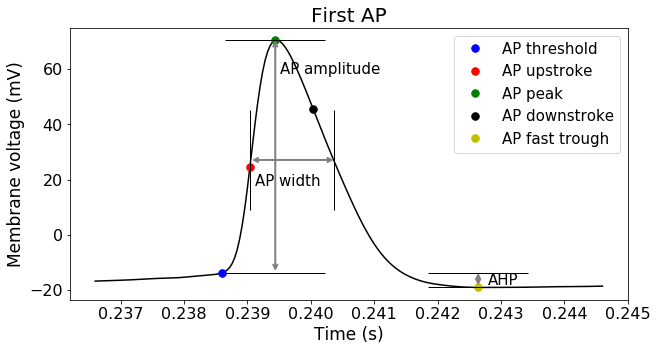

In [40]:
plot_info_first_peak(data)

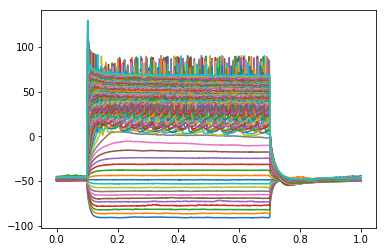

In [50]:
plt.plot(time, voltage);

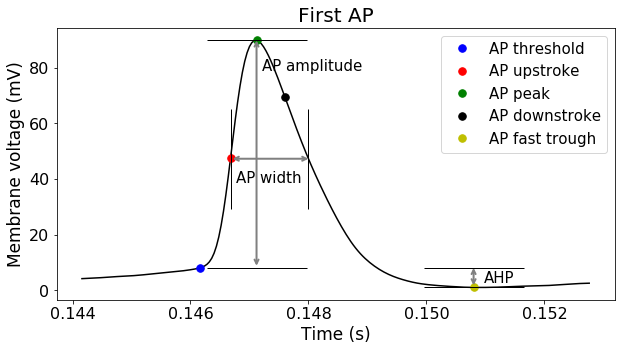

In [49]:
plot_info_first_peak(data)

In [20]:
def plot_info_first_peak_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data, el_num = el_num, current_step = current_step)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [ ]:
directory = '../M1/Figures/PlotInfoFirstPeak/'
plot_info_first_peak_all(M1, M1_names, directory)

We're in the even amount of traces showing the max freq
Max freq:  19


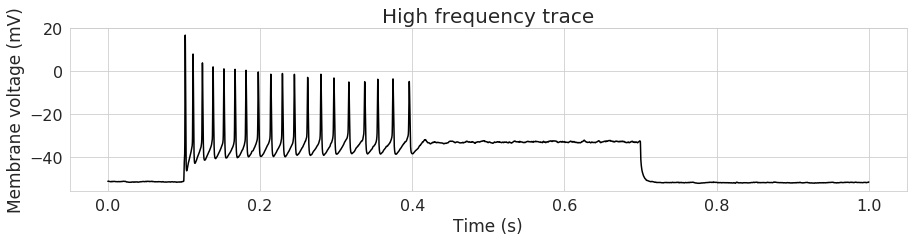

In [42]:
plot_max_spikes_trace(data_SFA)

In [73]:
def plot_max_spikes_trace(data, el_num = 2, current_step = 20, start = 0.1, end = 0.7, axis = None):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with the trace for which
    the features ISI FF, ISI CV, AP amp FF, AP amp CV, max # number of spikes in 600 ms and the Spike frequency adaptation
    are normally calculated (only in the very specific case of more traces showing the same max # of spikes in 600 ms can
    the trace for which the feature is being calculated differ among the features). Works for data extracted from .mat files,
    not for .asc files.
    
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    -------
    ax : figure object
    """
    
    time, current, voltage, curr_index_0 = data_preparation(data, el_num = el_num, current_step = current_step)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage)
    Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)
    plt.close()


    # The max amount of spikes in 600 ms of the trace showing the max amount of spikes in 600 ms
    max_freq = np.max(df_related_features['spike_count'].values)
    # Take the first trace showing this many spikes if there are many
    current_max_freq = np.flatnonzero(df_related_features['spike_count'].values >= max_freq)[0]
    # Check if there are peaks outside the stimilation interval for the highest firing trace. When true, continue looking
    # for lower firing traces untill it shows none anymore.
    artifact_occurence = False
    EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                              v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                              i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                              start = end, end = time[-1])
    EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)], \
                                                  v = voltage[:ft.find_time_index(time, start), current_max_freq], \
                                                  i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                  start = 0, end = start - (time[1] - time[0]))
    EphysObject_end.process_spikes()
    EphysObject_start.process_spikes()
    if EphysObject_end._spikes_df.size or EphysObject_start._spikes_df.size:
                artifact_occurence = True
    while artifact_occurence:
        current_max_freq-=1

        EphysObject_end = efex.EphysSweepFeatureExtractor(t = time[ft.find_time_index(time, end):], \
                                                  v = voltage[ft.find_time_index(time, end):, current_max_freq], \
                                                  i = np.zeros_like(time[ft.find_time_index(time, end):]), \
                                                  start = end, end = time[-1])
        EphysObject_start = efex.EphysSweepFeatureExtractor(t = time[:ft.find_time_index(time, start)], \
                                                  v = voltage[:ft.find_time_index(time, start), current_max_freq], \
                                                  i = np.zeros_like(time[:ft.find_time_index(time, start)]), \
                                                  start = 0, end = start - (time[1] - time[0]))
        EphysObject_end.process_spikes()
        EphysObject_start.process_spikes()
        if not EphysObject_end._spikes_df.size and not EphysObject_start._spikes_df.size:
            artifact_occurence = False
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (15, 3))
    sns.set_context(rc={'lines.markeredgewidth': 1})
    
    
    if time[-1] < 0.9:
        ax.plot(time, voltage[:,current_max_freq], color='black')
    else:
        ax.plot(time[:ft.find_time_index(time, 0.9)], voltage[:ft.find_time_index(time, 0.9), current_max_freq], \
                    color = 'black')
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_title('Highest frequency trace', fontsize = 20)
    return ax

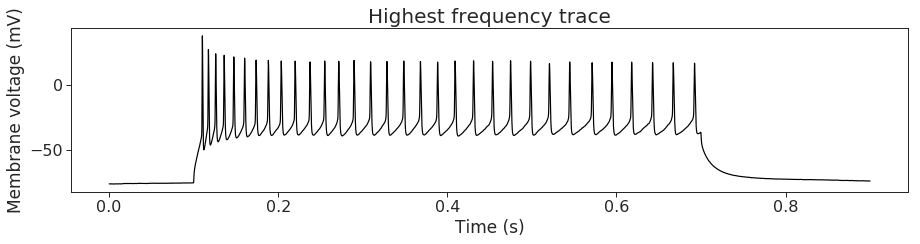

In [25]:
plot_max_spikes_trace(data)

In [76]:
def plot_lowest_trace(data, el_num = 2, current_step = 20, start = 0.1, end = 0.7, axis = None):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    -------
    ax : figure object
    """
    
    from matplotlib.patches import Polygon
    
    time, current, voltage, curr_index_0 = data_preparation(data, el_num = 2, current_step = 20)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, curr_index_0)
    plt.close()
    
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 10))
    if time[-1] < 0.9:
        ax.plot(time, voltage[:,0], color=np.array([0,0,0]), label=None)
    else:
        ax.plot(time[:ft.find_time_index(time, 0.9)], voltage[:ft.find_time_index(time, 0.9), 0], \
                    color = np.array([0,0,0]), label=None)
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.set_title('Lowest trace', fontsize = 20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    
    baseline_interval = 0.1 # To calculate the SS voltage
    
    
    #v_baseline = EphysObject._get_baseline_voltage()
    v_baseline = ft.average_voltage(voltage[:, 0], time, start = start - 0.1, end = start)
    
    start_index = ft.find_time_index(time, start)
    end_index = ft.find_time_index(time, end)
    index_rebound = end_index + 0.05 # Just a first initial value
    
    if np.flatnonzero(voltage[end_index:, 0] > v_baseline).size == 0: # So perfectly zero here means
                                                                      # it did not reach it
        rebound = 0
    else:
        index_rebound = end_index + np.flatnonzero(voltage[end_index:, 0] > v_baseline)[0]
        if not (time[index_rebound] > (end + 0.2)): # We definitely have 100 ms left to calculate the rebound
            rebound = ft.average_voltage(voltage[index_rebound:index_rebound + ft.find_time_index(time, 0.15), 0], \
                                 time[index_rebound:index_rebound + ft.find_time_index(time, 0.15)]) - v_baseline
        else:                                       # Work with whatever time is left
            rebound = ft.average_voltage(voltage[index_rebound:, 0], \
                                 time[index_rebound:]) - v_baseline


    #v_peak, peak_index = EphysObject.voltage_deflection("min")
    
    peak_index = start_index + np.argmin(voltage[start_index:end_index, 0])
    ax.plot(time[peak_index], voltage[peak_index, 0], '.', c = [0, 0, 0], markersize = 15, label = 'Sag trough')
    v_steady = ft.average_voltage(voltage[:, 0], time, start = end - baseline_interval, end=end)

    # First time SS is reached after stimulus onset
    first_index = start_index + np.flatnonzero(voltage[start_index:peak_index, 0] < v_steady)[0]
    # First time SS is reached after the max voltage deflection downwards in the sag
    if np.flatnonzero(voltage[peak_index:end_index, 0] > v_steady).size == 0: 
        second_index = end_index
    else:
        second_index = peak_index + np.flatnonzero(voltage[peak_index:end_index, 0] > v_steady)[0]
    # Time_to_SS is the time difference between these two time points
    time_to_SS = time[second_index] - time[first_index]
    # Integration_to_SS is the integration area of the voltage between these two time points
    integration_to_SS = -integrate.cumtrapz(voltage[first_index:second_index, 0], time[first_index:second_index])[-1]
    
    # Now let's add nice annotations
    # First up the time and integration to reach the SS
    ax.plot(time[first_index], voltage[first_index, 0], '|', markersize = 30, color = [0, 0, 0])
    ax.plot(time[second_index], voltage[second_index, 0], '|', markersize = 30, color = [0, 0, 0])
    ax.annotate('', xy = (time[first_index], voltage[first_index, 0]), \
            xycoords = 'data', xytext = (time[second_index], voltage[second_index, 0]), \
            textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', \
                                               'lw': 2, 'ec': 'grey', 'shrinkA': 0})
    ax.annotate('sag time', xy=(time[first_index] + time_to_SS/2, v_steady), \
             xycoords='data', xytext=(5, 5), textcoords='offset points', fontsize = 15)
    a, b = time[first_index], time[second_index]
    verts = [(a, voltage[first_index, 0]), *zip(time[first_index:second_index], voltage[first_index:second_index, 0]), \
             (b, voltage[second_index, 0])] 
    poly = Polygon(verts, facecolor = '0.9', edgecolor = '0.5')
    ax.add_patch(poly)
     
    # Now the rebound
    if rebound != 0:
        end_index_for_rebound = index_rebound + ft.find_time_index(time, 0.15)
        if (time[index_rebound] > (0.9 - 0.15)):
            end_index_for_rebound = ft.find_time_index(time, np.max(time)) # Plot till the end (simply what you have left)
        ax.plot(time[index_rebound], voltage[index_rebound, 0], '|',
                            markersize = 10, color = [0, 0, 0])
        ax.plot(time[end_index_for_rebound], voltage[end_index_for_rebound, 0], '|', \
                            markersize = 10, color = [0, 0, 0])
        if time[index_rebound] == time[end_index_for_rebound]:
            return ax
        ax.plot([time[index_rebound],  time[end_index_for_rebound]], \
                [ft.average_voltage(voltage[index_rebound:end_index_for_rebound, 0], \
                                 time[index_rebound:end_index_for_rebound]), \
                 ft.average_voltage(voltage[index_rebound:end_index_for_rebound, 0], \
                                 time[index_rebound:end_index_for_rebound])], '-',  \
                 color = [0, 0, 0])
        ax.plot([time[index_rebound], time[end_index_for_rebound]], [v_baseline, v_baseline], '-', \
                 color = [0, 0, 0])
        ax.annotate('', xy = (time[index_rebound] + (time[end_index_for_rebound] - time[index_rebound])/2, \
                              v_baseline), \
            xycoords = 'data', xytext = (time[index_rebound] + (time[end_index_for_rebound] - time[index_rebound])/2, \
                                         v_baseline + rebound), \
            textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', \
                                               'lw': 2, 'ec': 'grey', 'shrinkB': 0})
        ax.annotate('rebound', xy=(time[index_rebound] + (time[end_index_for_rebound] - time[index_rebound])/2, \
                                   v_baseline + rebound/2), \
             xycoords='data', xytext=(0, 2), textcoords='offset points', fontsize = 15)
    plt.legend(fontsize = 15)
    return ax

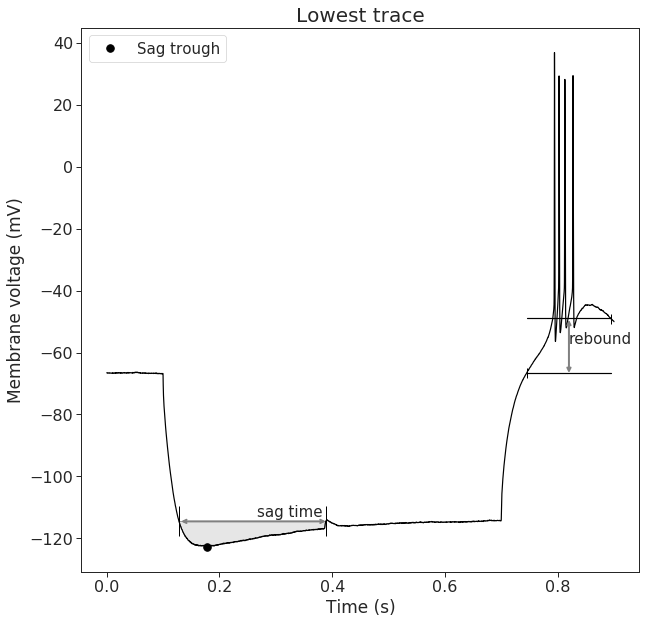

In [23]:
plot_lowest_trace(data)

In [38]:
def plot_w_style(data, el_num = 2, current_step = 20, start = 0.1, end = 0.7, axes = None):
    """Analyses a specific data dictionary corresponding to a cell and returns axes with traces and annotations.
    Works for data extracted from .mat files, not for.asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    axes : figure objects
    
    """
    time, current, voltage, curr_index_0 = data_preparation(data, el_num = el_num, current_step = current_step)
    
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, start = start, end = end, fil = filter_)
    
    sns.set_style('ticks')
    sns.set_context('paper', font_scale=.85)
    if axes:
        axes = axes
    else:
        fig = plt.figure(figsize = (20, 18))
        ax1 = plt.subplot2grid((4, 2), (0, 0))
        ax2 = plt.subplot2grid((4, 2), (0, 1))
        ax3 = plt.subplot2grid((4, 2), (1, 0))
        ax4 = plt.subplot2grid((4, 2), (1, 1))
        ax5 = plt.subplot2grid((4, 2), (2, 0))
        ax6 = plt.subplot2grid((4, 2), (2, 1))
        axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    prel_inspection(data, axis = axes[0])
    plot_info(data, el_num = el_num, current_step = current_step, start = start, end = end, axis = axes[1])
    plot_info_first_peak(data, el_num = el_num, current_step = current_step, start = start, end = end, axis = axes[2])
    Cell_Features = get_cell_features(df, df_related_features, time, current, voltage, \
                                      curr_index_0 = curr_index_0, axis = axes[3])
    plot_max_spikes_trace(data, axis = axes[4])
    plot_lowest_trace(data, axis = axes[5])
    plt.tight_layout()
    for axis in axes:
        sns.despine(ax = axis)
    sns.set_context(rc={'lines.markeredgewidth': 3})
    plt.text(-0.05, 1.04, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.04, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.04, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.04, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.04, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.04, 'f', transform = plt.gcf().get_axes()[5].transAxes, fontsize=25, fontweight='bold')
    return axes

In [18]:
# The data used for the Figure in the paper.
data = io.loadmat('../M1/2018/Nov/11 12 2018/11 12 2018 sample 11.mat')

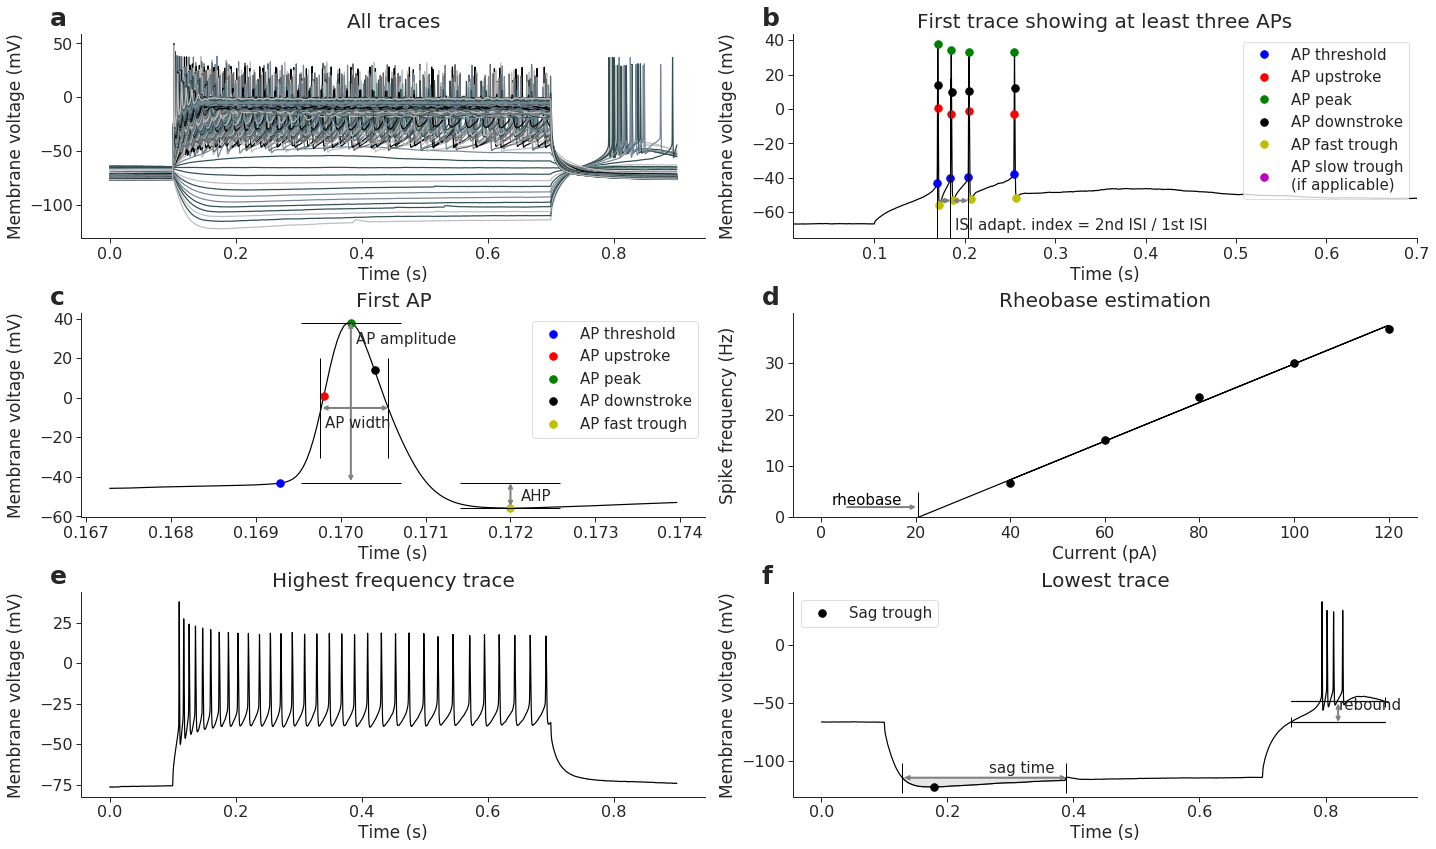

In [28]:
fig = plt.figure(figsize = (20, 15))
ax1 = plt.subplot2grid((4, 2), (0, 0))
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 0))
ax4 = plt.subplot2grid((4, 2), (1, 1))
ax5 = plt.subplot2grid((4, 2), (2, 0))
ax6 = plt.subplot2grid((4, 2), (2, 1))
fig.align_labels()

plot_w_style(data, axes = [ax1, ax2, ax3, ax4, ax5, ax6])
plt.savefig('SanityCheckPlot.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0.5)

In [41]:
def plot_w_style_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        fig = plt.figure(figsize = (20, 15))
        ax1 = plt.subplot2grid((4, 2), (0, 0))
        ax2 = plt.subplot2grid((4, 2), (0, 1))
        ax3 = plt.subplot2grid((4, 2), (1, 0))
        ax4 = plt.subplot2grid((4, 2), (1, 1))
        ax5 = plt.subplot2grid((4, 2), (2, 0))
        ax6 = plt.subplot2grid((4, 2), (2, 1))
        axes = plot_w_style(data, el_num = el_num, current_step = current_step, axes = [ax1, ax2, ax3, ax4, ax5, ax6])
        fig.suptitle(name.split('/')[-1].split('.')[0], y = 1.1, fontsize = 25)
        fig.align_labels()
        plt.savefig('{}{}.png'.format(directory, name), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [61]:
cells_w_ephys=['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
                                      g.split('/')[-1].split(' ')[1], '_sample_', \
                                      g.split('/')[-1].split(' ')[-1].split('.')[0]) \
                   for g in M1_names]

In [78]:
plot_w_style_all(M1, cells_w_ephys, '../M1/Figures/StylePlot/')

Processing:  20180918_sample_1
Processing:  20180918_sample_2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  20180918_sample_3
Processing:  20180917_sample_4
Processing:  20180917_sample_1
Processing:  20180917_sample_2
Processing:  20180917_sample_5
Processing:  20180917_sample_3
Processing:  20180911_sample_1
Processing:  20180911_sample_6
Processing:  20180911_sample_2
Processing:  20180911_sample_3
Processing:  20180911_sample_5
Processing:  20180905_sample_2
Processing:  20180905_sample_1
Processing:  20180910_sample_2
Processing:  20180910_sample_3
Processing:  20180925_sample_9
Processing:  20180926_sample_3
Processing:  20180926_sample_9
Processing:  20180926_sample_7
Processing:  20180926_sample_4
Processing:  20180926_sample_1
Processing:  20180913_sample_2
Processing:  20180927_sample_4
Processing:  20180927_sample_9
Processing:  20180927_sample_3
Processing:  20180927_sample_5
Processing:  20180927_sample_1
Processing:  20180927_sample_10
Processing:  20180927_sample_7
Processing:  20180927_sample_2
Processing:  20180921_sample_3
Processing:  20180921_sample_1
Process

MemoryError: Unable to allocate 352. KiB for an array with shape (22500, 2) and data type float64

MemoryError: In RendererAgg: Out of memory

<Figure size 1440x1080 with 6 Axes>

In [ ]:
plot_w_style_all(M1_no_biocytin, M1_names_no_biocytin, '../M1/Figures/StylePlot/NoBiocytin/')